In [1]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [2]:
# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

class SimDetectorCamV33(SimDetectorCam):
    '''This is used to update the SimDetectorCam to AD33.'''

    wait_for_plugins = Cpt(EpicsSignal, 'WaitForPlugins',
                           string=True, kind='config')

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs['wait_for_plugins'] = 'Yes'

    def ensure_nonblocking(self):
        self.stage_sigs['wait_for_plugins'] = 'Yes'
        for c in self.parent.component_names:
            cpt = getattr(self.parent, c)
            if cpt is self:
                continue
            if hasattr(cpt, 'ensure_nonblocking'):
                cpt.ensure_nonblocking()
    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCamV33, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')

def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.cam.ensure_nonblocking()



In [3]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')


In [20]:
my_sim_cam.wait_for_connection()

In [21]:
set_detector(my_sim_cam)


In [22]:
import databroker.core
handler_registry = databroker.core.discover_handlers()


In [29]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 2     Time: 2021-06-24 10:47:46
Persistent Unique Scan ID: '2da8f4c2-d272-45ff-b7bd-761805f0d04c'
New stream: 'primary'
+-----------+------------+------------------+
|   seq_num |       time | test_stats_total |
+-----------+------------+------------------+
|         1 | 10:47:46.3 |        133712608 |
+-----------+------------+------------------+
generator count ['2da8f4c2'] (scan num: 2)





('2da8f4c2-d272-45ff-b7bd-761805f0d04c',)

In [30]:
run = db[-1]

In [31]:
ls /home/emil/Apps/autosave/images/

3a56a0a7-bd8a-458c-b460_000000.tiff  c4d4cb28-ecac-4a15-9a93_000000.tiff
3d3f9c98-a94f-4224-906c_000000.tiff  c4f83825-db64-46d2-8e20_000000.tiff
52aede23-b7f3-4308-ae24_000000.tiff  c614ee9a-e0da-4cd2-8d9b_000000.tiff
5c749204-16d7-493b-80a1_000000.tiff  d36c1ba8-5d9a-43a8-8051_000000.tiff
701df64a-6911-4edf-89b9_000000.tiff  d3a75c12-8f1d-4989-aeeb_000000.tiff
77de774b-8aa0-4e4d-a1a1_000000.tiff  ddc99332-00fe-43c6-b580_000000.tiff
85529d9f-8974-46b0-84a5_000000.tiff  de0872c3-d260-4dfd-8f58_000000.tiff
9f6b161f-221d-4f3d-a731_000000.tiff  ea38ee7b-59f2-41b1-9e8c_000000.tiff
b682341a-de46-4995-b49e_000000.tiff


In [32]:
list(run)


['primary']

In [33]:
image = run.primary.read()["test_image"]


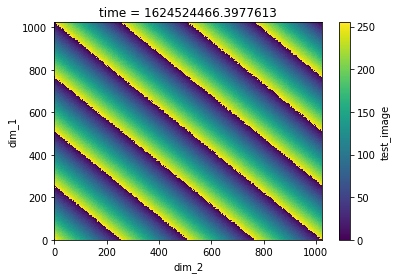

In [34]:

frame =image[0][0]
frame.plot.pcolormesh()
